In [187]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from operator import truediv

from collections import Counter
import itertools

In [188]:
G = nx.DiGraph()

In [189]:
def insert_node(name, email, learn, teach):
    G.add_node(name, email=email, learn=learn, teach=teach)
    
    for node in G.nodes(data=True):
        learn_other = node[1]['learn']
        teach_other = node[1]['teach']
        
        w = len([l for l in learn if l in teach_other])
        G.add_edge(name, node[0], weight=w)
        
        w = len([l for l in teach if l in learn_other])
        G.add_edge(node[0], name, weight=w)

In [190]:
# Retrieve data from Google Sheet and parse using pandas dataframe
data = pd.read_csv("https://raw.githubusercontent.com/benelson/collaboratr/master/collaboratr.csv")
data = data.replace(np.nan,' ', regex=True)
users = data['1. What is your name?']
emails = data['2. What is your email?']
teach = data['3. What can you help others with?']
learn = data['4. What do you want to collaborate on or learn about?']

In [191]:
# 
big_list = []
for i in range(len(teach)):
    big_list.append(teach[i].split(';'))

big_list1 = []
for i in range(len(learn)):
    big_list1.append(learn[i].split(';'))

In [192]:
all_teach = list((itertools.chain.from_iterable(big_list)))
N_teach = Counter(all_teach).values()

In [193]:
all_learn = list((itertools.chain.from_iterable(big_list1)))
N_learn = Counter(all_learn).values()

In [197]:
ratios =  map(truediv,N_learn,N_teach)

In [195]:
breakout_pct = .2
N = len(users)
subjects = Counter(all_teach).keys()
isBreakout = (np.array(ratios) > 2) & (np.array(N_learn > breakout_pct*N))

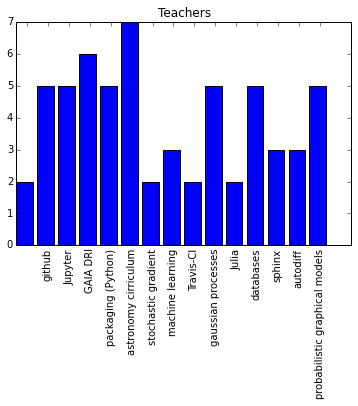

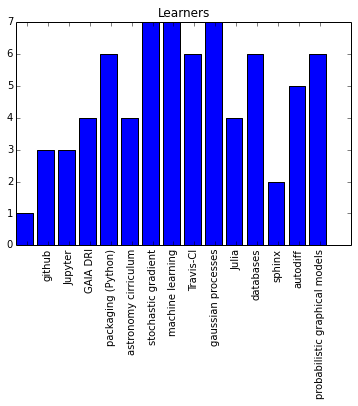

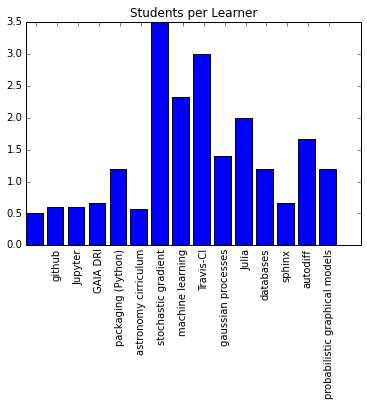

In [219]:
plt.figure()
plt.bar(range(len(subjects)), N_teach)
plt.xticks(np.arange(len(subjects))+.5,subjects,rotation=90)
plt.title('Teachers')

plt.figure()
plt.bar(range(len(subjects)), N_learn)
plt.xticks(np.arange(len(subjects))+.5,subjects,rotation=90)
plt.title('Learners')

plt.figure()
plt.title('Students per Learner')
plt.bar(range(len(subjects)), map(truediv,N_learn,N_teach))
plt.xticks(np.arange(len(subjects))+.5,subjects,rotation=90);

In [211]:
np.array(subjects)[list(np.where(isBreakout)[0])]

array(['stochastic gradient', 'machine learning', 'Travis-CI'], 
      dtype='|S30')

## Graphs

In [97]:
[insert_node(u, email=e, learn=l.split(';'), teach=t.split(';')) for u,e,t,l in zip(users, emails, learn, teach)]
pass

In [100]:
G.edges(data=True)

[('Paul', 'Abdullah Ahmed', {'weight': 0}),
 ('Paul', 'Know Nothing', {'weight': 0}),
 ('Paul', 'Laura Green', {'weight': 0}),
 ('Paul', 'Ben Nelson', {'weight': 0}),
 ('Paul', 'Walter White', {'weight': 0}),
 ('Paul', 'Usman Khan', {'weight': 1}),
 ('Paul', 'A Student', {'weight': 2}),
 ('Paul', 'Natali', {'weight': 0}),
 ('Paul', 'John Johnson', {'weight': 0}),
 ('Paul', 'Alice', {'weight': 0}),
 ('Paul', 'Barack Obama', {'weight': 1}),
 ('Paul', 'Bobcat Goldthwait', {'weight': 0}),
 ('Paul', 'Fred Rasio', {'weight': 0}),
 ('Paul', 'Paul', {'weight': 1}),
 ('Paul', 'Phil Marshall', {'weight': 0}),
 ('Paul', 'Mike Baumer', {'weight': 0}),
 ('Abdullah Ahmed', 'Paul', {'weight': 1}),
 ('Abdullah Ahmed', 'Abdullah Ahmed', {'weight': 0}),
 ('Abdullah Ahmed', 'Know Nothing', {'weight': 0}),
 ('Abdullah Ahmed', 'Laura Green', {'weight': 1}),
 ('Abdullah Ahmed', 'Ben Nelson', {'weight': 1}),
 ('Abdullah Ahmed', 'Usman Khan', {'weight': 3}),
 ('Abdullah Ahmed', 'A Student', {'weight': 3}),
 (